# Loading the data

In [91]:
import pandas as pd

df = pd.read_csv(
    "train.tsv",
    sep="\t",
    header=None,
    names=["text", "labels", "id"],
    quoting=3,
    encoding="utf-8"
)
df.head()

,text,labels,id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


# Taking insights from data

In [92]:
df.shape

(43410, 3)

In [93]:
len(df['labels'].unique())

711

In [94]:
df['labels'].value_counts()

,count
labels,
27,12823
0,2710
4,1873
15,1857
1,1652
...,...
"11,13",1
"0,5,20",1
"9,20,25",1


In [95]:
df.isnull().sum()

,0
text,0
labels,0
id,0


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    43410 non-null  object
 1   labels  43410 non-null  object
 2   id      43410 non-null  object
dtypes: object(3)
memory usage: 1017.6+ KB


In [97]:
df.head()

,text,labels,id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


# Text cleaning

In [98]:
import re

In [99]:

def clean_text(text):
    text = re.sub(r"http\S+", "", text)       # remove URLs
    text = re.sub(r"@\w+", "", text)          # remove @mentions
    text = re.sub(r"#", "", text)             # remove hashtags symbol
    text = re.sub(r" ", " ", text)            # normalize spaces (optional)
    text = re.sub(r"[^\w\s.,!?]", "", text)   # remove special characters except .,!?
    text = re.sub(r"\s+", " ", text)          # collapse multiple spaces
    return text.strip().lower()

In [100]:
df["clean_text"] = df['text'].apply(clean_text)

In [101]:
df.head()

,text,labels,id,clean_text
0,My favourite food is anything I didn't have to...,27,eebbqej,my favourite food is anything i didnt have to ...
1,"Now if he does off himself, everyone will thin...",27,ed00q6i,"now if he does off himself, everyone will thin..."
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj,why the fuck is bayless isoing
3,To make her feel threatened,14,ed7ypvh,to make her feel threatened
4,Dirty Southern Wankers,3,ed0bdzj,dirty southern wankers


# Tokenization

In [102]:
from nltk.tokenize import word_tokenize
import nltk
def tokenize(text):
    return word_tokenize(text)

In [103]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [104]:
tokenized_text = df['clean_text'].apply(tokenize)

# Building vocab

In [105]:
from collections import Counter

all_tokens = []
for tokens in tokenized_text:
    for text in tokens:
        all_tokens.append(text)
freqency = Counter(all_tokens)

In [106]:
vocab = {"<PAD>":0, '<UNK>':1}

for word, count in freqency.items():
    if count > 3:
        vocab[word] = len(vocab)
len(vocab)

7648

# Converting Text to indices

In [107]:
def text_2_indices(vocab, text):
    indexed_text=[]
    for tokens in text:
        seq=[]
        for token in tokens:
            if token in vocab:
                seq.append(vocab[token])
            else:
                seq.append(vocab["<UNK>"])
        indexed_text.append(seq)
    return indexed_text

In [108]:
indexed_text = text_2_indices(vocab=vocab, text=tokenized_text)

# Padding the text indices

In [109]:
max_len  = 0
for text in indexed_text:
    if len(text) > max_len:
        max_len = len(text)
max_len

35

In [110]:
padded_text = []

for tokens in indexed_text:
    if len(tokens) < max_len:
        tokens = tokens + [vocab['<PAD>']] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    padded_text.append(tokens)


In [111]:
import torch

In [112]:
labels = df['labels']
labels

,labels
0,27
1,27
2,2
3,14
4,3
...,...
43405,18
43406,6
43407,3
43408,13


# Building dataset and dataloader

In [113]:
num_classes = 28

multi_hot_labels = []

for lbl in labels:
    indices = str(lbl).split(",")
    vec = [0]*num_classes
    for i in indices:
        if i.isdigit():
            vec[int(i)] = 1
    multi_hot_labels.append(vec)



In [114]:
X = torch.tensor(padded_text, dtype=torch.long)
y = torch.tensor(multi_hot_labels, dtype=torch.float)

In [115]:
from torch.utils.data import Dataset, DataLoader, random_split

In [116]:
class GoEmotions(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [117]:
dataset = GoEmotions(X, y)

In [118]:
for text, label in dataset:
    print(text, labels)
    break

tensor([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]) 0        27
1        27
2         2
3        14
4         3
         ..
43405    18
43406     6
43407     3
43408    13
43409    17
Name: labels, Length: 43410, dtype: object


In [119]:
train_size = int(0.80*len(dataset))
val_size   = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [120]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [121]:
for text, label in train_loader:
    print(text, labels)
    break

tensor([[ 154,  155,   20,  ...,    0,    0,    0],
        [ 210,  481,   32,  ...,    0,    0,    0],
        [2540,  385,    5,  ...,    0,    0,    0],
        ...,
        [ 959,    5,  294,  ...,    0,    0,    0],
        [1281,   46,  626,  ...,    0,    0,    0],
        [ 360,   58,   20,  ...,    0,    0,    0]]) 0        27
1        27
2         2
3        14
4         3
         ..
43405    18
43406     6
43407     3
43408    13
43409    17
Name: labels, Length: 43410, dtype: object


In [122]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [123]:
import torch.nn as nn

# Building Bidirectional LSTM

In [124]:
class GoEmotions_lstm(nn.Module):
    def __init__(self, vocab_size, embed_dim=200, hidden_dim=256, num_classes=28, nun_layers=2):
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.lstm = nn.LSTM(input_size=embed_dim,
                            hidden_size=hidden_dim,
                            num_layers=nun_layers,
                            batch_first=True,
                            dropout=0.2,
                            bidirectional=True)

        self.fc = nn.Linear(hidden_dim*2 , num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)

        out, (h, c) = self.lstm(x)
        h_forward = h[-2]
        h_backward = h[-1]

        h_cat = torch.cat((h_forward, h_backward), dim=1)

        h_cat = self.dropout(h_cat)

        out = self.fc(h_cat)

        return out

# Setting up the model and optimizer

In [125]:
model = GoEmotions_lstm(vocab_size=len(vocab)).to(device)
model

GoEmotions_lstm(
  (embeddings): Embedding(7648, 200, padding_idx=0)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=28, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [126]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
epochs=60

In [127]:
from tqdm import tqdm

# Training the model

In [128]:
train_loss = []
for epoch in range(epochs):

    model.train()
    running_loss    =   0
    correct         =   0
    total           =   0

    for text, labels in tqdm(train_loader):

        labels = labels.float().to(device)
        text = text.to(device)

        optimizer.zero_grad()
        outputs = model(text)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total += len(labels)

        prods = torch.sigmoid(outputs)
        preds = (prods > 0.3).int()

        batch_correct = (preds == labels).all(dim=1).sum().item()
        correct += batch_correct


    accuracy = (correct/total)
    training_loss = running_loss/len(train_loader)
    train_loss.append(training_loss)

    print(f"EPOCH: {epoch+1}, LOSS: {training_loss}, ACCURACY : {accuracy:.2f}%")


100%|██████████| 1086/1086 [00:10<00:00, 103.33it/s]


EPOCH: 1, LOSS: 0.13405228242909273, ACCURACY : 0.31%


100%|██████████| 1086/1086 [00:10<00:00, 104.31it/s]


EPOCH: 2, LOSS: 0.1113011436211031, ACCURACY : 0.39%


100%|██████████| 1086/1086 [00:10<00:00, 108.04it/s]


EPOCH: 3, LOSS: 0.10283468495265445, ACCURACY : 0.41%


100%|██████████| 1086/1086 [00:10<00:00, 105.56it/s]


EPOCH: 4, LOSS: 0.09721951206552609, ACCURACY : 0.42%


100%|██████████| 1086/1086 [00:10<00:00, 101.95it/s]


EPOCH: 5, LOSS: 0.09361966314826771, ACCURACY : 0.43%


100%|██████████| 1086/1086 [00:10<00:00, 101.49it/s]


EPOCH: 6, LOSS: 0.09072239879127694, ACCURACY : 0.43%


100%|██████████| 1086/1086 [00:12<00:00, 90.09it/s] 


EPOCH: 7, LOSS: 0.08836241339849614, ACCURACY : 0.44%


100%|██████████| 1086/1086 [00:10<00:00, 99.47it/s] 


EPOCH: 8, LOSS: 0.08608902951712766, ACCURACY : 0.44%


100%|██████████| 1086/1086 [00:10<00:00, 100.51it/s]


EPOCH: 9, LOSS: 0.08381438345869602, ACCURACY : 0.45%


100%|██████████| 1086/1086 [00:10<00:00, 100.86it/s]


EPOCH: 10, LOSS: 0.08185839894164224, ACCURACY : 0.46%


100%|██████████| 1086/1086 [00:10<00:00, 101.65it/s]


EPOCH: 11, LOSS: 0.07958133804781661, ACCURACY : 0.47%


100%|██████████| 1086/1086 [00:10<00:00, 103.22it/s]


EPOCH: 12, LOSS: 0.07731105973789705, ACCURACY : 0.48%


100%|██████████| 1086/1086 [00:10<00:00, 105.16it/s]


EPOCH: 13, LOSS: 0.07532993458472123, ACCURACY : 0.49%


100%|██████████| 1086/1086 [00:10<00:00, 100.75it/s]


EPOCH: 14, LOSS: 0.07290139291469783, ACCURACY : 0.50%


100%|██████████| 1086/1086 [00:10<00:00, 100.85it/s]


EPOCH: 15, LOSS: 0.07052373924527598, ACCURACY : 0.51%


100%|██████████| 1086/1086 [00:10<00:00, 100.23it/s]


EPOCH: 16, LOSS: 0.06813942597798221, ACCURACY : 0.52%


100%|██████████| 1086/1086 [00:10<00:00, 100.75it/s]


EPOCH: 17, LOSS: 0.06605140782522233, ACCURACY : 0.54%


100%|██████████| 1086/1086 [00:10<00:00, 101.27it/s]


EPOCH: 18, LOSS: 0.06366440304254849, ACCURACY : 0.55%


100%|██████████| 1086/1086 [00:10<00:00, 101.09it/s]


EPOCH: 19, LOSS: 0.06188105067673858, ACCURACY : 0.56%


100%|██████████| 1086/1086 [00:10<00:00, 101.66it/s]


EPOCH: 20, LOSS: 0.05978002165775218, ACCURACY : 0.58%


100%|██████████| 1086/1086 [00:10<00:00, 102.49it/s]


EPOCH: 21, LOSS: 0.05777732416829626, ACCURACY : 0.59%


100%|██████████| 1086/1086 [00:10<00:00, 104.56it/s]


EPOCH: 22, LOSS: 0.056011532104023584, ACCURACY : 0.60%


100%|██████████| 1086/1086 [00:10<00:00, 100.84it/s]


EPOCH: 23, LOSS: 0.05451391939533459, ACCURACY : 0.61%


100%|██████████| 1086/1086 [00:10<00:00, 100.61it/s]


EPOCH: 24, LOSS: 0.052912142083158586, ACCURACY : 0.61%


100%|██████████| 1086/1086 [00:10<00:00, 100.75it/s]


EPOCH: 25, LOSS: 0.051359969820710616, ACCURACY : 0.62%


100%|██████████| 1086/1086 [00:10<00:00, 100.55it/s]


EPOCH: 26, LOSS: 0.0497351302731007, ACCURACY : 0.63%


100%|██████████| 1086/1086 [00:10<00:00, 100.53it/s]


EPOCH: 27, LOSS: 0.04867084759320124, ACCURACY : 0.64%


100%|██████████| 1086/1086 [00:10<00:00, 100.75it/s]


EPOCH: 28, LOSS: 0.04722448661546077, ACCURACY : 0.65%


100%|██████████| 1086/1086 [00:10<00:00, 100.88it/s]


EPOCH: 29, LOSS: 0.046430564878258036, ACCURACY : 0.65%


100%|██████████| 1086/1086 [00:10<00:00, 102.70it/s]


EPOCH: 30, LOSS: 0.04507894569092034, ACCURACY : 0.66%


100%|██████████| 1086/1086 [00:10<00:00, 104.42it/s]


EPOCH: 31, LOSS: 0.04394787755618163, ACCURACY : 0.67%


100%|██████████| 1086/1086 [00:10<00:00, 101.37it/s]


EPOCH: 32, LOSS: 0.043275970607159, ACCURACY : 0.67%


100%|██████████| 1086/1086 [00:10<00:00, 101.06it/s]


EPOCH: 33, LOSS: 0.042434995366229536, ACCURACY : 0.68%


100%|██████████| 1086/1086 [00:10<00:00, 101.08it/s]


EPOCH: 34, LOSS: 0.04143130176393641, ACCURACY : 0.68%


100%|██████████| 1086/1086 [00:10<00:00, 101.25it/s]


EPOCH: 35, LOSS: 0.040820243507692276, ACCURACY : 0.68%


100%|██████████| 1086/1086 [00:10<00:00, 100.95it/s]


EPOCH: 36, LOSS: 0.03975667182568797, ACCURACY : 0.69%


100%|██████████| 1086/1086 [00:12<00:00, 84.86it/s]


EPOCH: 37, LOSS: 0.039212293031026864, ACCURACY : 0.70%


100%|██████████| 1086/1086 [00:11<00:00, 96.28it/s] 


EPOCH: 38, LOSS: 0.038623536780003194, ACCURACY : 0.70%


100%|██████████| 1086/1086 [00:10<00:00, 100.98it/s]


EPOCH: 39, LOSS: 0.037571758410891665, ACCURACY : 0.71%


100%|██████████| 1086/1086 [00:10<00:00, 101.13it/s]


EPOCH: 40, LOSS: 0.037500599239700734, ACCURACY : 0.71%


100%|██████████| 1086/1086 [00:10<00:00, 103.22it/s]


EPOCH: 41, LOSS: 0.036473968417021836, ACCURACY : 0.72%


100%|██████████| 1086/1086 [00:10<00:00, 103.55it/s]


EPOCH: 42, LOSS: 0.03613251494844041, ACCURACY : 0.72%


100%|██████████| 1086/1086 [00:10<00:00, 101.04it/s]


EPOCH: 43, LOSS: 0.03553669428295056, ACCURACY : 0.72%


100%|██████████| 1086/1086 [00:10<00:00, 100.65it/s]


EPOCH: 44, LOSS: 0.03508758341334417, ACCURACY : 0.72%


100%|██████████| 1086/1086 [00:12<00:00, 87.92it/s] 


EPOCH: 45, LOSS: 0.03424255309616169, ACCURACY : 0.73%


100%|██████████| 1086/1086 [00:10<00:00, 101.05it/s]


EPOCH: 46, LOSS: 0.034193838528883996, ACCURACY : 0.73%


100%|██████████| 1086/1086 [00:10<00:00, 100.29it/s]


EPOCH: 47, LOSS: 0.033379449815237223, ACCURACY : 0.73%


100%|██████████| 1086/1086 [00:10<00:00, 100.90it/s]


EPOCH: 48, LOSS: 0.032950474819748166, ACCURACY : 0.74%


100%|██████████| 1086/1086 [00:10<00:00, 101.23it/s]


EPOCH: 49, LOSS: 0.032869205525415925, ACCURACY : 0.74%


100%|██████████| 1086/1086 [00:10<00:00, 100.75it/s]


EPOCH: 50, LOSS: 0.0323916421817276, ACCURACY : 0.74%


100%|██████████| 1086/1086 [00:10<00:00, 103.71it/s]


EPOCH: 51, LOSS: 0.03165040213038414, ACCURACY : 0.75%


100%|██████████| 1086/1086 [00:10<00:00, 103.44it/s]


EPOCH: 52, LOSS: 0.03190702221203685, ACCURACY : 0.74%


100%|██████████| 1086/1086 [00:10<00:00, 100.65it/s]


EPOCH: 53, LOSS: 0.03127779873322977, ACCURACY : 0.75%


100%|██████████| 1086/1086 [00:10<00:00, 101.05it/s]


EPOCH: 54, LOSS: 0.030495728753699235, ACCURACY : 0.75%


100%|██████████| 1086/1086 [00:11<00:00, 93.85it/s] 


EPOCH: 55, LOSS: 0.030427087137808347, ACCURACY : 0.75%


100%|██████████| 1086/1086 [00:10<00:00, 100.65it/s]


EPOCH: 56, LOSS: 0.030268258997453567, ACCURACY : 0.75%


100%|██████████| 1086/1086 [00:10<00:00, 101.08it/s]


EPOCH: 57, LOSS: 0.030263439389408786, ACCURACY : 0.75%


100%|██████████| 1086/1086 [00:10<00:00, 100.74it/s]


EPOCH: 58, LOSS: 0.029636304393328355, ACCURACY : 0.75%


100%|██████████| 1086/1086 [00:10<00:00, 100.89it/s]


EPOCH: 59, LOSS: 0.029269988522530425, ACCURACY : 0.76%


100%|██████████| 1086/1086 [00:10<00:00, 101.64it/s]

EPOCH: 60, LOSS: 0.029111283330476634, ACCURACY : 0.76%


# Validating the model with MICRO & MACRO F1

In [133]:
from sklearn.metrics import f1_score
import numpy as np

model.eval()
all_preds = []
all_labels = []
total = 0
correct = 0
accuracies = []

with torch.no_grad():
    for text, labels in tqdm(val_loader):

        labels = labels.float().to(device)
        text = text.to(device)

        outputs = model(text)
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.3).int()

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu().int())

        total += labels.size(0)
        batch_correct = (preds == labels).all(dim=1).sum().item()
        correct += batch_correct

        accuracies.append(correct/total)


all_preds = torch.cat(all_preds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

micro_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

subset_acc = (all_preds == all_labels).all(axis=1).mean()

print(f"MICRO F1 : {micro_f1:.4f}")
print(f"MACRO F1 : {macro_f1:.4f}")
print(f"SUBSET ACCURACY : {subset_acc:.4f}")

100%|██████████| 272/272 [00:00<00:00, 283.19it/s]

MICRO F1 : 0.4708
MACRO F1 : 0.3786
SUBSET ACCURACY : 0.3287


# Plotting the progress

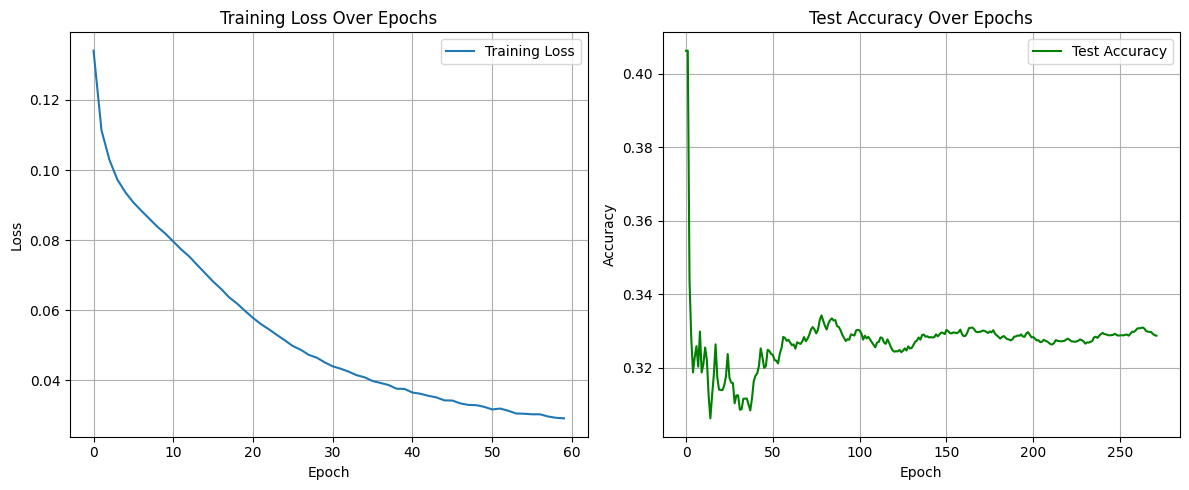

In [134]:

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Quick infrance of the model

In [135]:
import torch
import re
from nltk.tokenize import word_tokenize

# label index → emotion name mapping
emotion_map = [
    "admiration","amusement","anger","annoyance","approval","caring","confusion",
    "curiosity","desire","disappointment","disapproval","disgust","embarrassment",
    "excitement","fear","gratitude","grief","joy","love","nervousness","optimism",
    "pride","realization","relief","remorse","sadness","surprise","neutral"
]

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def predict_emotions(text, model, vocab, max_len=40, threshold=0.3):
    model.eval()

    # 1. preprocess
    text = clean_text(text)
    tokens = word_tokenize(text)

    # 2. convert to indices
    seq = [vocab.get(tok, 1) for tok in tokens]  # <UNK>=1

    # 3. pad/truncate
    if len(seq) < max_len:
        seq += [vocab["<PAD>"]] * (max_len - len(seq))
    else:
        seq = seq[:max_len]

    # 4. tensor
    x = torch.tensor([seq], dtype=torch.long)

    # 5. MOVE INPUT TO SAME DEVICE AS MODEL
    device = next(model.parameters()).device
    x = x.to(device)

    # 6. forward pass
    with torch.no_grad():
        logits = model(x)
        probs = torch.sigmoid(logits).squeeze(0).cpu()

    # 7. thresholding
    preds = (probs > threshold).int()

    # 8. get emotion names
    emotions = [emotion_map[i] for i,p in enumerate(preds) if p == 1]

    if len(emotions) == 0:
        return ["neutral"]

    return emotions



In [136]:
print(predict_emotions("I love this movie so much!", model, vocab))
print(predict_emotions("I hate you, leave me alone", model, vocab))
print(predict_emotions("It's okay I guess", model, vocab))
print(predict_emotions("I'm nervous but excited for tomorrow", model, vocab))


['love']
['anger']
['neutral']
['nervousness']


# Saving the model

In [137]:
checkpoint = {
    "model_state": model.state_dict(),
    "vocab": vocab,
    "max_len": max_len,
    "threshold": 0.3
}
torch.save(checkpoint, "goemotions_bilstm_checkpoint.pth")
